In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
from sklearn.model_selection import KFold
import pickle
import pandas as pd
import os.path
file_name = '../resampled_2x5_cross_validation'
if os.path.isfile(file_name+'.pickle'): 
    with open(file_name+'.pickle', 'rb') as handle:
        train_folds,test_folds = pickle.load(handle)  

In [3]:

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
class RnnType:
    GRU = 1
    LSTM = 2

class AttentionModel:
    NONE = 0
    DOT = 1
    GENERAL = 2
    CONCAT = 3

class Parameters:
    def __init__(self, data_dict):
        for k, v in data_dict.items():
            exec("self.%s=%s" % (k, v))
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, bidirectional=False, method='GRU',device=device):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.n_directions = 2 if bidirectional else 1
        self.method = method
        self.device=device
        if self.method == 'GRU':
            self.net = nn.GRU(input_size,
                              self.hidden_size,
                              num_layers=self.n_layers,
                              bidirectional=self.bidirectional,
                              batch_first=True)
        elif self.method == 'LSTM':
            self.net = nn.LSTM(input_size,
                               self.hidden_size,
                               num_layers=self.n_layers,
                               bidirectional=self.bidirectional,
                               batch_first=True
                              )
        self.to(self.device)
    def forward(self, input):
        hidden  = self.init_hidden(input.shape[0])
        output, hidden = self.net(input,
                                  hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        if self.method == 'GRU':
            return torch.zeros(self.n_layers * self.n_directions, 
                               batch_size, 
                               self.hidden_size).to(self.device)
        elif self.method == 'LSTM':
            return (torch.zeros(self.n_layers * self.n_directions, 
                               batch_size, 
                               self.hidden_size).to(self.device),
                    torch.zeros(self.n_layers * self.n_directions, 
                               batch_size, 
                               self.hidden_size).to(self.device))
        else:
            raise Exception('Unknown rnn_type. Valid options: "gru", "lstm"')

class Decoder(nn.Module):
    def __init__(self, device, params):
        super(Decoder, self).__init__()
        self.params = params
        self.device = device

        # Calculate number of directions
        self.num_directions = 2 if self.params.bidirectional == True else 1

        # RNN layer
        rnn = None
        if self.params.rnn_type == RnnType.GRU:
            rnn = nn.GRU
        elif self.params.rnn_type == RnnType.LSTM:
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RnnType. Currently supported: RnnType.GRU=1, RnnType.LSTM=2")
        self.rnn = rnn(input_size = self.params.rnn_hidden_dim*self.num_directions,
                       hidden_size = self.params.rnn_hidden_dim,
                       num_layers=self.params.num_layers,
                       bidirectional=self.params.bidirectional,
                       dropout=self.params.dropout,
                       batch_first=True)
        self.encoder = EncoderRNN(input_size = 1, 
                                  hidden_size = self.params.rnn_hidden_dim, 
                                  n_layers=self.params.num_layers,
                                  bidirectional=self.params.bidirectional, 
                                  method='GRU',
                                  device=device)
        self.decoder_input = nn.Sequential(
            torch.nn.Linear(self.params.sequence_length, self.params.layer_width),
            torch.nn.ReLU(),
            torch.nn.Linear(self.params.layer_width, self.params.output_sequence_length),
            torch.nn.Sigmoid()
        )
        self.linear = nn.Sequential(
            torch.nn.Linear(self.params.rnn_hidden_dim*self.num_directions, self.params.layer_width),
            torch.nn.ReLU(),
            torch.nn.Linear(self.params.layer_width, 1),
            torch.nn.Sigmoid()
        )
        self.to(device)


    def init_hidden(self, batch_size):
        if self.params.rnn_type == RnnType.GRU:
            return torch.zeros(self.params.num_layers * self.num_directions, batch_size, self.params.rnn_hidden_dim).to(self.device)
        elif self.params.rnn_type == RnnType.LSTM:
            return (torch.zeros(self.params.num_layers * self.num_directions, batch_size, self.params.rnn_hidden_dim).to(self.device),
                    torch.zeros(self.params.num_layers * self.num_directions, batch_size, self.params.rnn_hidden_dim).to(self.device))
        else:
            raise Exception('Unknown rnn_type. Valid options: "gru", "lstm"')
    def forward(self,inputs):
        inputs=inputs.unsqueeze(2)
        batch_size, seq_len,_ = inputs.shape #to encoder
        #encoder_outputs (batch_size, input_seq_len, self.n_layers * self.n_directions)
        #encoder_hidden ( self.n_layers * self.n_directions, batch_size, hidden size)
        encoder_outputs, encoder_hidden = self.encoder(inputs) 
        decoder_inputs = self.decoder_input(encoder_outputs.transpose(1,2)).transpose(1,2)
        # self.hidden = self.init_hidden(batch_size)
        # Push through RNN layer
        rnn_output, _ = self.rnn(decoder_inputs, encoder_hidden)
        # (batch_size, output_seq_len, num_directions*hidden)
        spectrum_out = self.linear(rnn_output)
        return spectrum_out.squeeze(2)

    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            # print("Initialize layer with nn.init.xavier_uniform_: {}".format(layer))
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

In [4]:
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
class CalculateMSE():
    def __init__(self, net,n_epochs,batch_size ):
        super().__init__()
        self.net = net
        #initialize some constants
        self.batch_size = 32
        self.learning_rate = 1e-4
        self.n_epochs = n_epochs
        self.net.apply(self.weights_init)   
    def weights_init(self,layer):
        if type(layer) == nn.Linear:
            nn.init.orthogonal_(layer.weight)
    def get_mse(self,train_data, train_label, test_data, test_label):
        train_set = torch.utils.data.TensorDataset(
            torch.Tensor(train_data), 
            torch.Tensor(train_label))
        val_set = torch.utils.data.TensorDataset(
            torch.Tensor(test_data), 
            torch.Tensor(test_label))
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **loader_args)
        val_loader = DataLoader(val_set, shuffle=True, drop_last=True, **loader_args)
        tloss = []
        vloss = []
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate) # weight_decay=0
        for epoch in range(0, self.n_epochs):
            epoch_train_loss=[]
            for i, data in enumerate(train_loader, 0):
                inputs, label = data
                y_pred = self.net(inputs.to(self.net.device))
                loss = criterion(y_pred, label.to(self.net.device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_train_loss.append(loss.item())
            tloss.append(np.mean(epoch_train_loss))
            epoch_loss=[]
            for i, data in enumerate(val_loader, 0):
                with torch.no_grad():
                    inputs1, label1 = data
                    y_pred1 = self.net(inputs1.to(self.net.device))
                    loss1 = criterion(y_pred1, label1.to(self.net.device))
                    epoch_loss.append(loss1.item())
            vloss.append(np.mean(epoch_loss))
        return np.min(vloss), self.net


In [5]:
from pathlib import Path
n_epochs=3000
batch_size=32
PATH = '../saved_model/seq2seqv1_combined_poisson_25percent/'
Path(PATH).mkdir(parents=True, exist_ok=True)
params = {'rnn_type':RnnType.GRU,
          'rnn_hidden_dim': 8,
          'layer_width':512,
          'num_layers':1,
          'dropout':0,
          'attention_model':AttentionModel.GENERAL,
          'sequence_length':64,
          'output_sequence_length':250,
          'bidirectional':True}
params  =Parameters(params)
mdl =  Decoder(device,params)
losses=[]
def add_noise(inputs,inputs2, a = 0.02, std = 0.02, sequence_length=64, noise_seed=None):
    if noise_seed is not None:
        np.random.seed(noise_seed)
    noise = np.random.normal(0,std, size = (inputs.shape[0], sequence_length)).astype(np.float32)
    noise2 = np.random.normal(0,std, size = (inputs2.shape[0], sequence_length)).astype(np.float32)
    #noise = poisson.rvs(mu, size=(inputs.shape[0], sequence_length)).astype(np.float32)
    
    nsd = a*np.random.poisson(inputs/a).astype(np.float32)
    nsd2 = a*np.random.poisson(inputs2/a).astype(np.float32)
    
    # Calculate the absolute error between nsd and original inputs
    absolute_error = np.abs(nsd - inputs)
    absolute_error2 = np.abs(nsd2 - inputs2)
    # Sum up the absolute errors
    total_error = np.sum(absolute_error)
    total_error2 = np.sum(absolute_error2)
    # Sum of the original data
    total_original = np.sum(inputs)
    total_original2 = np.sum(inputs2)

    # Calculate the noise ratio
    noise_ratio = (total_error+total_error2) / (total_original+total_original2)
    
    return nsd, nsd2, noise_ratio
for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.0403, std = 0.05, sequence_length=64, noise_seed=i)
    mse_calculator = CalculateMSE(mdl,n_epochs,batch_size)
    loss,model = mse_calculator.get_mse(train_data, train_label, test_data, test_label)
    print(i,loss)
    losses.append(loss)
    torch.save(model.state_dict(), PATH+'model'+str(i))

/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0 0.02340143881738186
1 0.02533491514623165
2 0.021129589155316354
3 0.024510331079363824
4 0.025495691411197185
5 0.02890406772494316
6 0.024718596041202544
7 0.03179293759167194
8 0.02804231196641922
9 0.03502613306045532


In [6]:

print(np.mean(losses),np.std(losses))

0.026835601199418302 0.003945665399784913


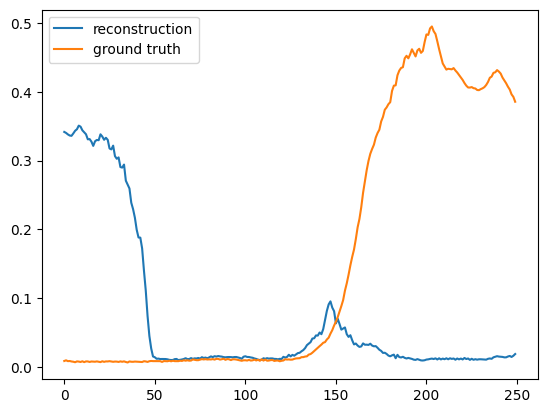

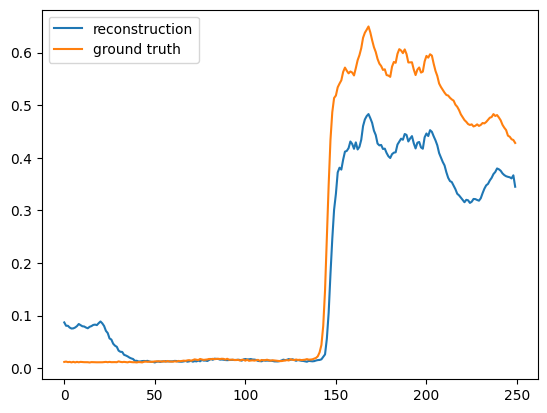

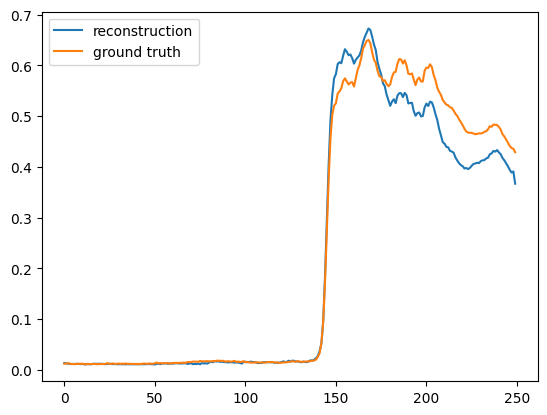

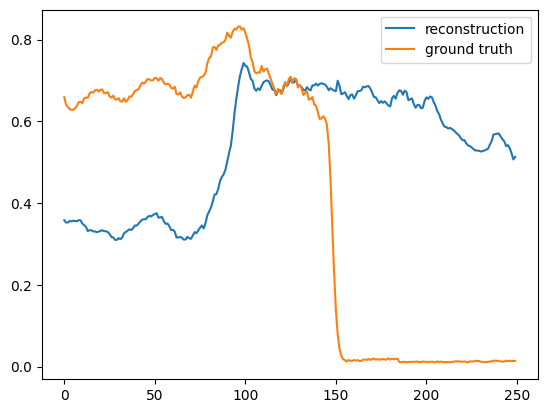

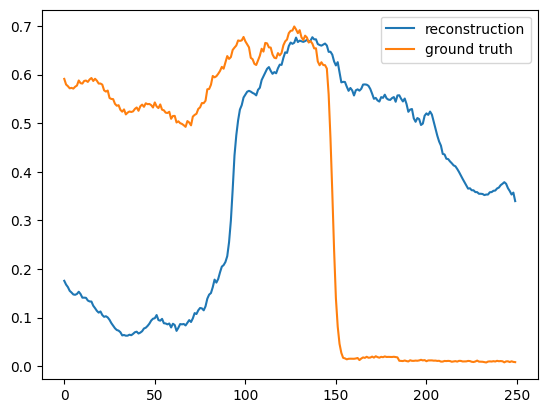

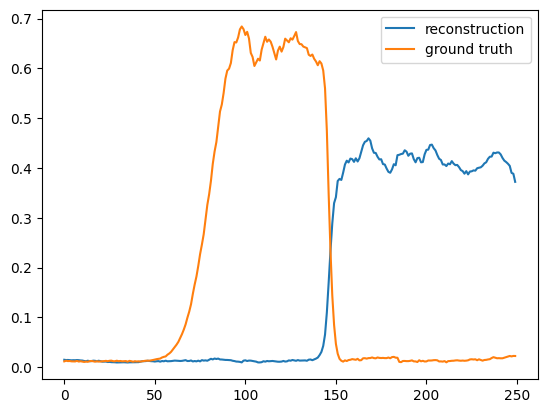

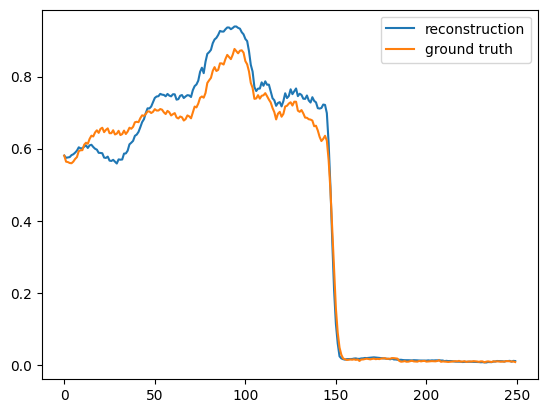

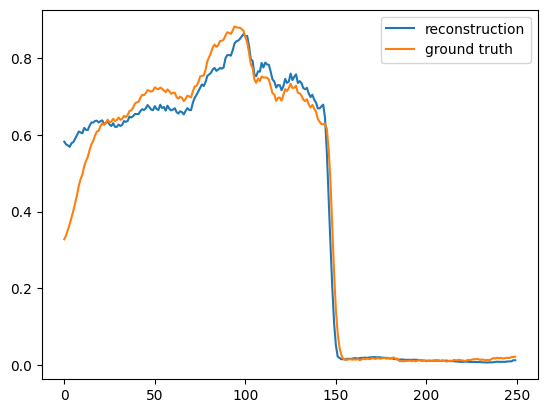

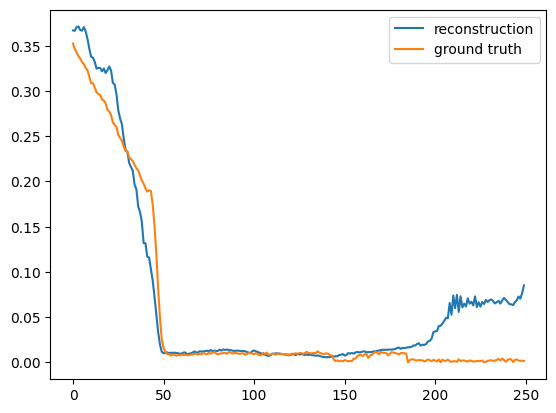

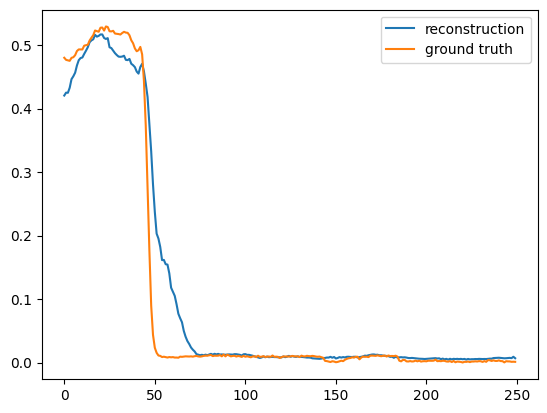

In [7]:
number_figures = 10
import matplotlib.pyplot as plt

indices = torch.randint(0,len(test_data),(number_figures,)).unique()
for i in indices:
    res = test_data[i].reshape(1,-1)
    spec = test_label[i]
    plt.figure(i)

    plt.plot(model(torch.Tensor(res).to(model.device)).detach().cpu().flatten())
    plt.plot(spec)
    plt.legend(['reconstruction','ground truth'])


In [8]:
from pathlib import Path

params = {'rnn_type':RnnType.GRU,
          'rnn_hidden_dim': 8,
          'layer_width':512,
          'num_layers':1,
          'dropout':0,
          'attention_model':AttentionModel.GENERAL,
          'sequence_length':64,
          'output_sequence_length':250,
          'bidirectional':True}
params  =Parameters(params)
mdl =  Decoder(device,params)

from scipy import stats
#pip install dtw-python
from dtw import *
import torch
import numpy as np

Path(PATH).mkdir(parents=True, exist_ok=True)
correlation_losses = []
import dcor
correlation_losses = []
def calculate_correlation(model, test_data, test_label):
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
    construction = model(test_data_tensor).detach().cpu().numpy()
   
    # Pearson
    pearson_coefs = []
    pearson_ps = []
    
    # Kendall
    kendall_coefs = []
    kendall_ps = []
    
    # Spearman
    spearman_coefs = []
    spearman_ps = []
    
    # Distance Correlation
    distance_corr = []
    
    #DTW distance
    alignment = []
    
    #absolute_error
    abs_err = []
    
    for i in range(test_label.shape[0]):
        x1 = construction[i,:]
        x2 = test_label[i,:]
        
        res = stats.pearsonr(x1, x2)
        pearson_coefs.append(res[0])
        pearson_ps.append(res[1])
        
        res = stats.kendalltau(x1, x2)
        kendall_coefs.append(res[0])
        kendall_ps.append(res[1])
        
        res = stats.spearmanr(x1, x2)
        spearman_coefs.append(res[0])
        spearman_ps.append(res[1])
        
        distance_corr.append(dcor.distance_correlation(x1,x2))
        
        alignment.append(dtw(x1, x2, distance_only=True).distance)
        abs_err.append(abs(x1-x2))
        
    correlation_results = {
        'pearson': (pearson_coefs, pearson_ps),
        'kendall': (kendall_coefs, kendall_ps),
        'spearman': (spearman_coefs, spearman_ps),
        'DTW': alignment,
        'Absolute Error': abs_err,
        'Distance Correlation': distance_corr
    }

    return correlation_results

for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.0403, std = 0.05, sequence_length=64, noise_seed=i)
    mdl_name = PATH + 'model' + str(i)
    mdl.load_state_dict(torch.load(mdl_name))
    mdl.eval()
    
    correlation_loss = calculate_correlation(mdl, test_data, test_label)
    correlation_losses.append(correlation_loss)
for key in correlation_losses[0].keys():
    print(key)
    if key=='Absolute Error':
        errors = []
        for d in correlation_losses:
            errors+=np.concatenate(d[key]).ravel().tolist()
        #percentile
        percentiles = [5, 50, 90, 95, 99]
        for p in percentiles:
            print(p)
            print(np.percentile(errors, p))
    else:
        stat, p = [], []
        for d in correlation_losses:
            if key=='DTW' or key=='Distance Correlation':
                stat+=d[key]
            else:
                stat+=d[key][0]
                p+=d[key][1]
        print(np.mean(stat),np.std(stat))
        if len(p)>0:
            print(np.mean(p),np.std(p))

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


pearson
0.6903031548417301 0.4471377649930179
0.015837459941342155 0.0942542903680664
kendall
0.4858013498973649 0.31399530600845343
0.020730137536549134 0.10728930629080154
spearman
0.6106543531613042 0.40195482174339325
0.02014981687242201 0.107808841018668
DTW
19.46005488635912 22.688495450708107
Absolute Error
5
0.0009167651766474157
50
0.04794723838068636
90
0.3430344021863685
95
0.4687549860355566
99
0.6599259085722291
Distance Correlation
0.8063533478595175 0.23050593646085918
